# Imports


This first section will cover all necessary imports and the ordinor package installation.

To be able to execute the code from the paper you will need to install a development version of the ordinor package as a local dependency which we have included in our folder structure. The installation of the development branch directly from GitHub didn't work for us which is why we decided to install it locally. To install this get your currenct path of the "OrdinoR-dev" folder, open a terminal and run the following code snippet: 

In [3]:
#insert your local path to the OrdinoR-dev folder and run this cell
#!pip install -e <path_to_ordinor>

Note: you may need to restart the kernel to use updated packages.


The syntax of the command is incorrect.


In [1]:
# import all required packages
import pm4py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import log
from pytz import timezone
from collections import defaultdict
from tree import TreeNode, TreePrinter
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from ordinor.execution_context.rule_based import ODTMiner
from ordinor.execution_context.rule_based.Rule import Rule
from ordinor.execution_context.rule_based.TreeNode import Node

# Preprocessing

## Data combination

From the paper we know that the author uses the dataset from the BPI Challange from 2015 which is actually split into five independent datasets from different municiplaities of the netherlands. Despite that there is no further information given. In his code repository he also only included the file "bpic15_amended_typed.csv" which we found out that this is already a combination of the preprocessed and combined datatset which also includes his resulting "execution contexts". In the following we will give our approach which lead to our successful replication.

In [6]:
# read and combine all five event logs of the BPIC15 Challenge
"""dfs = []
for i in range(1,6):
    log = pm4py.read_xes('base_xes_files/BPIC15_'+str(i)+'.xes')
    df = pm4py.convert_to_dataframe(log)
    
    # add a column with the municipality id to be able to distinguish between the five municipalities
    df["r:municipality"] = f"muni-{i}" 
    dfs.append(df)
combined_df = pd.concat(dfs, axis=0)"""


c:\Users\I516663\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 1156/1156 [00:07<00:00, 151.30it/s]


In [5]:
combined_df = pm4py.read_xes('data/raw/BPI_Challenge_2019-3-w-after.xes')
combined_df.to_csv("data/raw/bpic19.csv", index=False)

c:\Users\corde\AppData\Local\Programs\Python\Python310\lib\site-packages\pm4py\util\dt_parsing\parser.py:76: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/15182 [00:00<?, ?it/s]

## Timestamp manipulation

While trying to replicate the authors results we realized that there are differences in the timestamps of his preporcessed dataset (bpic15_amended_typed.csv) compared to data provided by the challenge. For example the timestamp always varies exactly 8 or 9 hours in comparison to the Netherland's local time in which the data was created. Another big difference ist that his timestamps don't include timezone information while the original data does.

After a deep investigation form our side why this is we realized that the authors location (based on his University) is likely to be Queensland, Australia. This fits the obsevered differences perfectly because in Queensland there is no summer or wintertime while in the Netherlands there is and therefore the time difference between both countries is either 8 or 9 hours.

To replicate his results we then manipulated all timestamps from the original data to match the Queensland timezone (AEST).

To illustrate the impact this has on the results we implemented his approach based on: 
1. his dataset, 
2. our replication dataset with AEST timestamps, 
3. using original timestamps from the challenge

In [7]:
"""# change time back to Amsterdam because pm4py automatically converts to UTC+0
amsterdam_tz = timezone('Europe/Amsterdam')
combined_df['time:timestamp'] = combined_df['time:timestamp'].dt.tz_convert(
    amsterdam_tz)

# save to file
combined_df.to_csv("data/raw/bpic15.csv", index=False)

# add 10 hours manually to get from UTC+0 to AEST timezone (UTC+10)
aest_tz = timezone('UTC')
combined_df['time:timestamp'] = combined_df['time:timestamp'].dt.tz_convert(
    aest_tz)
combined_df['time:timestamp'] = combined_df['time:timestamp'].apply(lambda ts: ts + pd.Timedelta(hours=10))

# save to file
combined_df.to_csv("data/raw/bpic15_AEST.csv", index=False)"""

## Execute the authors preprocessing code


After initially running the preprocessing we realized that the resulting dataset still is not exactly the same and used disco to come up with potential root causes. There we could see that the case count was higher by 1 and we could identify the missing case_id (4020737) in his dataset. We then contacted the author who confirmed that he manually deleted this case because it has more than one value for attribute “ct:permit_type”. Therefore we also included a line of code which deletes the case 4020737.

In [14]:
# Load raw data & Preprocess DataFrame (enrich with derived attributes)
# the following use of AT, CT, TT is specified by the author an refers to the "Activity type", "Case type" and "Time type" described in the paper

logs = ['bpic19']

for log in logs:
    fn = f'data/raw/{log}.csv'
    df = pd.read_csv(fn)[[
         'case:concept:name', 'concept:name', 'case:(case) Item Type', 'time:timestamp', 'User'
    ]]
    #'Case ID', 'Activity', 'Item Type', 'Complete Timestamp', 'User'
    
    df = df.rename(columns={
        # TT-related
        "time:timestamp": "Complete Timestamp",
        # CT-related
        'case:(case) Item Type':'Item Type',
        # AT-related
        "concept:name": "Activity",
        # Additional
        "case:concept:name": "Case ID"
    })
    
    # TODO: derive 'ct:permit_type', 'at:phase' --> specified by the author
    df = df[~df['Item Type'].isna()]
    df['ct:item_type'] = df['Item Type']
    df['at:phase'] = df['Activity']

    # only look at the main subprocess: "01_HOOFD" --> based on domain knowledge from the author
    df = df[~df['Activity'].isna()]

    # derive and append TT related candidate attributes
    df['Complete Timestamp'] = pd.to_datetime(
        df['Complete Timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
    MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    #df['tt:month'] = df['Complete Timestamp'].apply(lambda ts: MONTHS[ts.month-1])
    #df['tt:day'] = df['Complete Timestamp'].apply(
     #   lambda ts: 'Day_{}'.format(ts.day))
    WEEKDAYS = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    df['tt:weekday'] = df['Complete Timestamp'].apply(
        lambda ts: WEEKDAYS[ts.weekday()])
    df['tt:ampm'] = df['Complete Timestamp'].apply(
        lambda ts: 'AM' if ts.hour < 12 else 'PM')

    print(df)
    df.to_csv(f'data/processed/{log}.csv')

                 Case ID                    Activity Item Type  \
0       2000000001_00001                SRM: Created   Service   
1       2000000001_00001               SRM: Complete   Service   
2       2000000001_00001      SRM: Awaiting Approval   Service   
3       2000000001_00001     SRM: Document Completed   Service   
4       2000000001_00001                SRM: Ordered   Service   
...                  ...                         ...       ...   
319228  4508075963_00001  Record Service Entry Sheet   Service   
319229  4508075963_00001  Record Service Entry Sheet   Service   
319230  4508075963_00001  Record Service Entry Sheet   Service   
319231  4508075963_00001        Record Goods Receipt   Service   
319232  4508075963_00001        Record Goods Receipt   Service   

              Complete Timestamp      User ct:item_type  \
0      2018-01-03 08:49:00+00:00  batch_00      Service   
1      2018-01-03 09:49:00+00:00  batch_00      Service   
2      2018-01-03 09:49:00+00:

## Resulting visualization

The diagram created by following code now shows the impact of the timestamp manipulation. For example we can see that in the orignal dataset which is based on the netherlands timezone (legend: bpic15) information shows a lot of batch processing at midnight while looking at the authors dataset (legend: paper) these activities are split between 8AM and 9AM. The third bar (legend: bpic15_AEST) is our dataset after trying to replicate the authors results. There we can also see that the disribution of events is the same as his.

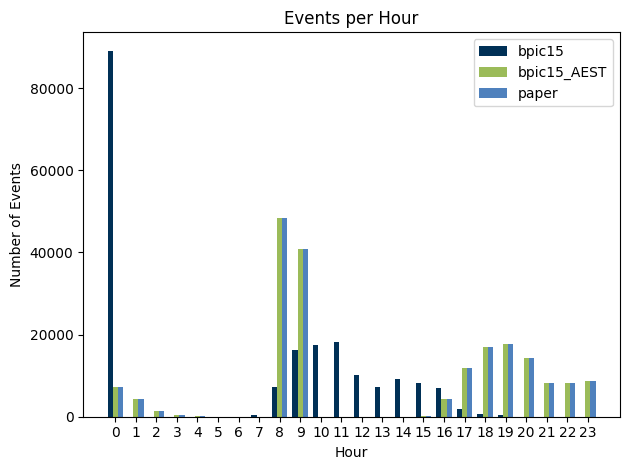

In [15]:
"""# read the data
df_bpic15 = pd.read_csv('data/processed/bpic15.csv')
df_bpic15_AEST = pd.read_csv('data/processed/bpic15_AEST.csv')
df_paper = pd.read_csv('data/processed/bpic15_amended_typed.csv')

# get hours
hours_bpic15 = df_bpic15['time:timestamp'].apply(lambda ts: ts[11:13])
hours_bpic15_AEST = df_bpic15_AEST['time:timestamp'].apply(lambda ts: ts[11:13])
hours_paper = df_paper['Complete Timestamp'].apply(lambda ts: ts[11:13])

# get counts
hours = np.arange(0, 24)
counts_df_bpic15 = np.bincount(hours_bpic15)
counts_df_bpic15_AEST = np.bincount(hours_bpic15_AEST)
counts_df_paper = np.bincount(hours_paper)

# Ensure that all counts arrays have the same length
max_len = max(len(counts_df_bpic15), len(
    counts_df_bpic15_AEST), len(counts_df_paper))
counts_df_bpic15 = np.pad(
    counts_df_bpic15, (0, max_len - len(counts_df_bpic15)), mode='constant')
counts_df_bpic15_AEST = np.pad(
    counts_df_bpic15_AEST, (0, max_len - len(counts_df_bpic15_AEST)), mode='constant')
counts_df_paper = np.pad(
    counts_df_paper, (0, max_len - len(counts_df_paper)), mode='constant')

# Plot the bar chart
fig, ax = plt.subplots()
width = 0.25  # the width of the bars
x = np.arange(len(hours))

rects1 = ax.bar(x - width, counts_df_bpic15, width,label='bpic15', color='#003056')
rects2 = ax.bar(x, counts_df_bpic15_AEST, width, label='bpic15_AEST', color='#9BBB59')
rects3 = ax.bar(x + width, counts_df_paper, width,label='paper', color='#4F81BD')

# Add text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Events')
ax.set_xlabel('Hour')
ax.set_title('Events per Hour')
ax.set_xticks(x)
ax.set_xticklabels(hours)
ax.legend()

fig.tight_layout()

plt.show()"""


# Execution of ODT(Oblivious Decision Tree)-Miner

In this section the ODT-Miner gets executed for each of the three datasets.

In [17]:
# define a fucntion to train the three different miners
def trainMiners(tree_height):
    # train miner based on the orignal data
    df_bpic19 = pd.read_csv('data/processed/bpic19.csv')
    
    """df = df.rename(columns={
        # TT-related
        "time:timestamp": "Complete Timestamp",
        # CT-related
        'case:(case) Item Type':'Item Type',
        # AT-related
        "concept:name": "Activity",
        # Additional
        "case:concept:name": "Case ID"
    })"""
    
    df_bpic19 = df_bpic19.rename(columns={
        # Resource-related
        "User": "org:resource",
        # TT-related
        "Complete Timestamp": "time:timestamp",
        # CT-related
        'Item Type': 'ct:last_phase',
        # AT-related
        "Activity": "concept:name",
        # Additional
        "Case ID": "case:concept:name"
    })
    
    spec = {
        'type_def_attrs': {
            # BPIC19
            'ct:item_type': {'attr_type': 'categorical', 'attr_dim': 'CT'},
            'at:phase': {'attr_type': 'categorical', 'attr_dim': 'AT'},
            'tt:weekday': {'attr_type': 'categorical', 'attr_dim': 'TT'},
            'tt:ampm': {'attr_type': 'categorical', 'attr_dim': 'TT'},
        }
    }

    # training the miners
    miner_bpic19 = ODTMiner(df_bpic19, spec, max_height=tree_height, trace_history=True)

    return miner_bpic19


miner_bpic19 = trainMiners(tree_height=7)





C:\Users\corde\OneDrive\Documents\GitHub\No-time-to-dice_group_project_IE692\OrdinoR-dev\ordinor\execution_context\rule_based\decision_tree.py:44: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  self._log = el[included_cols]
C:\Users\corde\OneDrive\Documents\GitHub\No-time-to-dice_group_project_IE692\OrdinoR-dev\ordinor\execution_context\rule_based\decision_tree.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._log[const.RESOURCE] = self._log[const.RESOURCE].astype('category')
C:\Users\corde\OneDrive\Documents\GitHub\No-time-to-dice_group_project_IE692\OrdinoR-dev\ordinor\execution_context\rule_based\decision_tree.py:50: SettingWithCopyWarning: 
A value is trying to be se

Decision tree initialized with an empty root node
	Dis. = 0.000000, Imp. = 1.000000, Harmonic Mean. = 0.000000, *** Tree has 1 leaf node(s). ***
Start to fit decision tree with max. height = 7
Tree grows by splitting all current leaf nodes on `ct:item_type`, step=1 (running for 00:00:54s)
	Dis. = 0.001436, Imp. = 0.986440, Harmonic Mean. = 0.002869, *** Tree has 2 leaf node(s). ***
Tree grows by splitting all current leaf nodes on `at:phase`, step=2 (running for 00:01:49s)
	Dis. = 0.006566, Imp. = 0.958355, Harmonic Mean. = 0.013044, *** Tree has 4 leaf node(s). ***
Tree grows by splitting all current leaf nodes on `tt:weekday`, step=3 (running for 00:03:16s)
	Dis. = 0.010063, Imp. = 0.955577, Harmonic Mean. = 0.019917, *** Tree has 6 leaf node(s). ***
Tree grows by splitting all current leaf nodes on `at:phase`, step=4 (running for 00:04:39s)
	Dis. = 0.012695, Imp. = 0.682189, Harmonic Mean. = 0.024925, *** Tree has 9 leaf node(s). ***
Tree grows by splitting all current leaf nodes on

To get a better understanding of what is happening within the execution of the ODT-Miner, we implemented a visualization of the resulting decision tree below. The output of this function is getting saved in the "trees" directory.


In [21]:
"""miners = [miner_bpic15, miner_bpic15_AEST, miner_paper]
miners_suffix = ['', 'bpic15_AEST', '_paper']

# start with preperations for visualizing
for position, miner in enumerate(miners):
    all_nodes_matrix = []
    all_events = []
    for node in miner.l_history_persistent[0]['solution'].values():
        all_events.extend(node.event_ids)

    root_node = Node(
        label=0,
        event_ids=all_events,
        ct_label=None,
        at_label=None,
        tt_label=None)
    root_TreeNode_in_list = []
    root_TreeNode_in_list = [
        TreeNode(root_node.label, root_node.parent_label, root_node, 0, None, [])]
    all_nodes_matrix.append(root_TreeNode_in_list)
    # i to be sure were we are when navigating the tree
    for i, step in enumerate(miner.l_history_persistent):
        all_nodes_this_step = []
        for node in step['solution'].values():
            current_node = TreeNode(
                node.label, node.parent_label, node, i+1, None, [])
            all_nodes_this_step.append(current_node)
        all_nodes_matrix.append(all_nodes_this_step)

    for i, all_nodes_this_step in enumerate(reversed(all_nodes_matrix)):
        for node in all_nodes_this_step:
            if node.parent_label is not None:
                candidate_parent = next((parent_node for parent_node in all_nodes_matrix[len(
                    all_nodes_matrix)-i-2] if parent_node.label == node.parent_label), None)
                if candidate_parent is not None:
                    node.parent = candidate_parent
                else:
                    node.parent = next((parent_node for parent_node in all_nodes_matrix[len(
                        all_nodes_matrix)-i-2] if parent_node.label == node.label))
                if node.parent is not None:
                    node.parent.children.append(node)


    treePrinter = TreePrinter(
        all_nodes_matrix[0][0],  # root node
        7,  # last step
        miner.l_history_persistent,  # miner history
        f'tree{miners_suffix[position]}' # output name
    )

    treePrinter.print_tree_svg()"""


In [ ]:
########## LASSSE PLEASE INSERT VERGLEICH ERGBNIS VON AEST FILT TO AMENDED TYPED --> Einfach zeigen dass des nun das exakt gleiche set ist --> bitte danke <3

As previously mentioned, the authors "bpic15_amended_typed.csv" file already includes his results of the ODT-Miner. To replicate this, we have also attached the resulting execution contexts to the events in the the dataset and saved it the new file "output.csv". We didn't do this for our AEST replica dataset, since the data is identical to the authors dataset.


In [18]:
def addDimensions(df, miner):
    # get different rules
    l_rules_ct, l_rules_at, l_rules_tt = miner._parse_rules_from_leaves(
        miner._leaves)

    # label ATs
    dfs = [r.apply(df, index_only=False).assign(AT_rule=r) for r in l_rules_at]
    df = pd.concat(dfs)

    # label CTs
    dfs = [r.apply(df, index_only=False).assign(CT_rule=r) for r in l_rules_ct]
    df = pd.concat(dfs)

    # label TTs
    dfs = [r.apply(df, index_only=False).assign(TT_rule=r) for r in l_rules_tt]
    df = pd.concat(dfs)

    # add CO_rule as combination of AT CT and TT
    df['CO_rule'] = df.apply(lambda x: Rule(x['AT_rule'].ars+x['CT_rule'].ars+x['TT_rule'].ars), axis=1)

    return df


# have to train miners again because i could not save the trained miners and the miners are changed by the last function
miner_bpic19 = trainMiners(tree_height=7) 

df_bpic19 = pd.read_csv('data/processed/bpic19.csv')
df_bpic19 = addDimensions(df_bpic19, miner_bpic19)
df_bpic19.to_csv('data/added_execution_contexts/bpic19.csv', index=False)



C:\Users\corde\OneDrive\Documents\GitHub\No-time-to-dice_group_project_IE692\OrdinoR-dev\ordinor\execution_context\rule_based\decision_tree.py:44: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  self._log = el[included_cols]
C:\Users\corde\OneDrive\Documents\GitHub\No-time-to-dice_group_project_IE692\OrdinoR-dev\ordinor\execution_context\rule_based\decision_tree.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._log[const.RESOURCE] = self._log[const.RESOURCE].astype('category')
C:\Users\corde\OneDrive\Documents\GitHub\No-time-to-dice_group_project_IE692\OrdinoR-dev\ordinor\execution_context\rule_based\decision_tree.py:50: SettingWithCopyWarning: 
A value is trying to be se

Decision tree initialized with an empty root node
	Dis. = 0.000000, Imp. = 1.000000, Harmonic Mean. = 0.000000, *** Tree has 1 leaf node(s). ***
Start to fit decision tree with max. height = 7
Tree grows by splitting all current leaf nodes on `ct:item_type`, step=1 (running for 00:01:05s)
	Dis. = 0.001436, Imp. = 0.986440, Harmonic Mean. = 0.002869, *** Tree has 2 leaf node(s). ***
Tree grows by splitting all current leaf nodes on `at:phase`, step=2 (running for 00:02:12s)
	Dis. = 0.009194, Imp. = 0.710548, Harmonic Mean. = 0.018153, *** Tree has 4 leaf node(s). ***
Tree grows by splitting all current leaf nodes on `at:phase`, step=3 (running for 00:04:22s)
	Dis. = 0.009194, Imp. = 0.686532, Harmonic Mean. = 0.018145, *** Tree has 5 leaf node(s). ***
Tree grows by splitting all current leaf nodes on `at:phase`, step=4 (running for 00:05:56s)
	Dis. = 0.009194, Imp. = 0.685934, Harmonic Mean. = 0.018144, *** Tree has 6 leaf node(s). ***
Tree grows by splitting all current leaf nodes on `

# Results of replication

This section will now cover what we have achieved and which deifferences exist. The goal of this paper was to create execution contexts which should be used to form culsters more effiecently than just using the acticity itself. To show his success, the author draws a graph which compares the silouhette scores, depending on the number of clusters. There you can see his generated execution contexts generally form better clusers than just using the activity. To make it easily compararble, we also inserted our resulting execution contexts's into the following diagram. You can also see that there are only minor differences between both results. At just around 32 execution contexts, his results have a slightly higher silouette score.

In [ ]:
#### --> linie fpr aest dataset hinzufügen auch wenns identisch ist

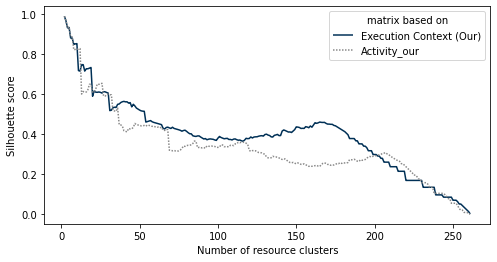

In [20]:
# show results of different miners
"""df = pd.read_csv('bpic15_amended_typed.csv')

X1 = df.groupby(['Resource', 'Activity']).size().unstack().fillna(0)
X2 = df.groupby(['Resource', 'CO']).size().unstack().fillna(0)


best_k = -1
best_score = -2

l_ss1 = []
l_ss2 = []
for k in range(2, len(X1)):
    clu1 = AgglomerativeClustering(n_clusters=k).fit_predict(X1)
    ss1 = silhouette_score(X1, clu1)
    l_ss1.append(ss1)
    clu2 = AgglomerativeClustering(n_clusters=k).fit_predict(X2)
    ss2 = silhouette_score(X2, clu2)
    l_ss2.append(ss2)



data = []
for i in range(len(l_ss1)):
    data.append({'k': i + 2, 'score': l_ss2[i], 'matrix based on': 'Execution Context (Paper)'})
    data.append({'k': i + 2, 'score': l_ss1[i], 'matrix based on': 'Activity'})"""


# <add our calculation to graph>
df = pd.read_csv('data/added_execution_contexts/bpic19.csv')

X1 = df.groupby(['User', 'Activity']).size().unstack().fillna(0)
X2 = df.groupby(['User', 'CO_rule']).size().unstack().fillna(0)

l_ss1 = []
l_ss2 = []
for k in range(2, len(X1)):
    clu1 = AgglomerativeClustering(n_clusters=k).fit_predict(X1)
    ss1 = silhouette_score(X1, clu1)
    l_ss1.append(ss1)
    clu2 = AgglomerativeClustering(n_clusters=k).fit_predict(X2)
    ss2 = silhouette_score(X2, clu2)
    l_ss2.append(ss2)
    
data = []

for i in range(len(l_ss1)):
    data.append({'k': i + 2, 'score': l_ss2[i], 'matrix based on': 'Execution Context (Our)'})
    data.append({'k': i + 2, 'score': l_ss1[i], 'matrix based on': 'Activity_our'}) 
# </add our calculation to graph>

data = pd.DataFrame(data)

data

f, ax = plt.subplots(figsize=(8, 4))
ax = sns.lineplot(data=data, x="k", y="score", ax=ax,
                  hue="matrix based on", style='matrix based on', 
                  palette={
                        'Activity_our': '#898989',
                        'Execution Context (Our)': '#003056'}, 
                    dashes={
                            'Activity_our': (1,1),
                            'Execution Context (Our)': (1, 0)})
plt.xlabel('Number of resource clusters')
plt.ylabel("Silhouette score")
plt.show()
f.savefig("graphs/omm_all.pdf", bbox_inches='tight')


Resource
560781      12644
560454      10170
560872       9503
560530       9295
560673       9243
            ...  
1898401         9
13412010        9
3175153         7
10716070        5
560427          2
Length: 71, dtype: int64
[560781, 560454, 560872, 560530, 560673, 560604, 560752, 560602, 560532, 560749, 2670601, 560890, 560741, 3273854, 560458, 560600, 560852, 2013365, 560519, 560429, 1254625, 1550894, 560912, 560696, 560821, 560521, 560608, 560925, 8492512, 560598, 11744364, 5025869, 3442724, 560596, 560462, 560881, 560613, 9264148, 22445896, 4634935, 560849, 560812, 560950, 3122446, 560894, 560594, 6993893, 560589, 20987361, 9106499, 5726485, 560922, 12941730, 560999, 560431, 6925826, 560528, 560464, 6, 3069866, 13412649, 11345232, 560796, 4936828, 560713, 3148844, 1898401, 13412010, 3175153, 10716070, 560427]
0     [560852, 1254625, 3148844, 560532, 560749, 560...
1     [560849, 560532, 560604, 560872, 560600, 56053...
2     [560849, 560429, 560604, 560532, 560922, 56087...


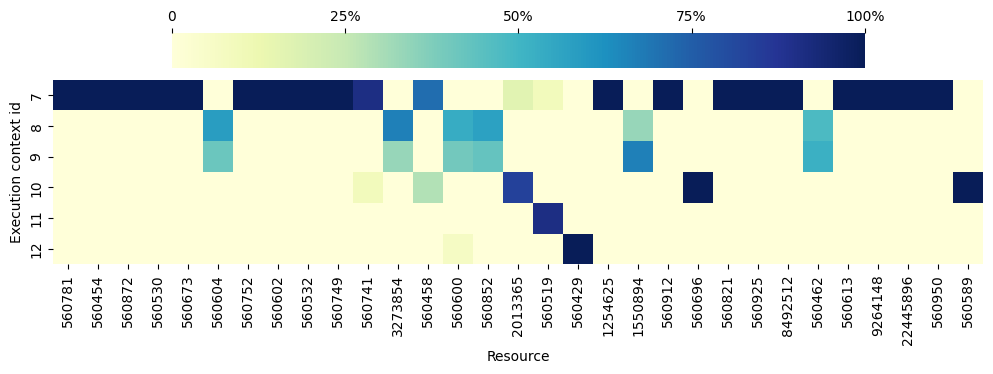

In [27]:
"""# matrix from paper
df = pd.read_csv('bpic15_amended_typed.csv')

df_res_events = df.groupby('Resource').size().sort_values(ascending=False).iloc[:]
print(df_res_events)
active_res = list(df_res_events.index)
print(active_res)

df = df[df['Resource'].isin(active_res)]


df_co_events = df.groupby(['AT', 'TT']).size(
).reset_index().sort_values(0, ascending=False)
df_co_events = df_co_events.rename(columns={0: 'n_events'}).reset_index()[
    ['AT', 'TT', 'n_events']]

df_co_res = df.groupby(['AT', 'TT'])['Resource'].unique()

df_x = df_co_events.join(df_co_res, on=['AT', 'TT'])
print(df_x['Resource'])

all_resources = sorted(df['Resource'].unique())

selected_resources = set()

# Jaccard distance
co_resources = []

for i, res in enumerate(df_x['Resource']):
    # print(set(sorted(res)))
    if i >= 6:
        for r in res:
            selected_resources.add(r)
    co_resources.append(set(res))

print(sorted(selected_resources))
print(len(selected_resources))

selected_resources = sorted(
    selected_resources, key=lambda x: active_res.index(x))
print(df_res_events.loc[selected_resources])

df_res_co_events = defaultdict(lambda: defaultdict(lambda: 0))
for key, events in df.groupby(['Resource', 'AT', 'TT']):
    r = key[0]
    at = key[1]
    tt = key[2]
    if at == '0-1-4-5' and tt == 'Sun':
        co = '7'
    elif at == '3' and tt == 'Sat':
        co = '8'
    elif at == '2' and tt == 'Sat':
        co = '9'
    elif at == '6' and tt == 'M-T-W-T-F':
        co = '10'
    elif at == '8' and tt == 'Sat':
        co = '11'
    elif at == '7' and tt == 'Sat':
        co = '12'
    else:
        co = 'others'
    df_res_co_events[r][co] = len(events)

df_res_co_events = pd.DataFrame(df_res_co_events).fillna(0).T
df_res_co_events = df_res_co_events[['7', '8', '9', '10', '11', '12']]
df_res_co_events = df_res_co_events.loc[selected_resources]
df_res_co_events = df_res_co_events.div(df_res_co_events.sum(axis=1), axis=0)

mat_jac_dist = defaultdict(lambda: defaultdict(lambda: 0))

for i in range(len(co_resources)):
    for j in range(len(co_resources)):
        u = co_resources[i]
        v = co_resources[j]
        mat_jac_dist[i+1][j+1] = 1 - len(u.intersection(v)) / len(u.union(v))

print(mat_jac_dist)

df_jac_dist = pd.DataFrame(mat_jac_dist).loc[1:7][list(range(1, 7+1))]
# df_jac_dist

f, ax = plt.subplots(figsize=(12, 3))
sns.heatmap(df_res_co_events.T, ax=ax, cmap='YlGnBu', annot=False,
            cbar_kws=dict(use_gridspec=False, location="top"))
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .25, .5, .75, 1])
cbar.set_ticklabels(['0', '25%', '50%', '75%', '100%'])
plt.xlabel("Resource")
plt.ylabel("Execution context id")
plt.show()
f.savefig("graphs/res_prof_paper.pdf", bbox_inches='tight')"""


In [ ]:
### die gleiche grafik mit unseren daten btite nochmal

In [31]:
"""# matrix from paper
df = pd.read_csv('output.csv')
df = df.rename(columns={
            "org:resource": "Resource",
            "AT_rule": "AT",
            "TT_rule": "TT",
            "CT_rule": "CT",
    })

df_res_events = df.groupby('Resource').size().sort_values(ascending=False).iloc[:]
print(df_res_events)
active_res = list(df_res_events.index)
print(active_res)

df = df[df['Resource'].isin(active_res)]


df_co_events = df.groupby(['AT', 'TT']).size(
).reset_index().sort_values(0, ascending=False)
df_co_events = df_co_events.rename(columns={0: 'n_events'}).reset_index()[
    ['AT', 'TT', 'n_events']]

df_co_res = df.groupby(['AT', 'TT'])['Resource'].unique()

df_x = df_co_events.join(df_co_res, on=['AT', 'TT'])
print(df_x['Resource'])

all_resources = sorted(df['Resource'].unique())

selected_resources = set()

# Jaccard distance
co_resources = []

for i, res in enumerate(df_x['Resource']):
    # print(set(sorted(res)))
    if i >= 6:
        for r in res:
            selected_resources.add(r)
    co_resources.append(set(res))

print(sorted(selected_resources))
print(len(selected_resources))

selected_resources = sorted(
    selected_resources, key=lambda x: active_res.index(x))
print(df_res_events.loc[selected_resources])

df_res_co_events = defaultdict(lambda: defaultdict(lambda: 0))
for key, events in df.groupby(['Resource', 'AT', 'TT']):
    r = key[0]
    at = key[1]
    tt = key[2]
    if at == '0-1-4-5' and tt == 'Sun':
        co = '7'
    elif at == '3' and tt == 'Sat':
        co = '8'
    elif at == '2' and tt == 'Sat':
        co = '9'
    elif at == '6' and tt == 'M-T-W-T-F':
        co = '10'
    elif at == '8' and tt == 'Sat':
        co = '11'
    elif at == '7' and tt == 'Sat':
        co = '12'
    else:
        co = 'others'
    df_res_co_events[r][co] = len(events)

df_res_co_events = pd.DataFrame(df_res_co_events).fillna(0).T
df_res_co_events = df_res_co_events[['7', '8', '9', '10', '11', '12']]
df_res_co_events = df_res_co_events.loc[selected_resources]
df_res_co_events = df_res_co_events.div(df_res_co_events.sum(axis=1), axis=0)

mat_jac_dist = defaultdict(lambda: defaultdict(lambda: 0))

for i in range(len(co_resources)):
    for j in range(len(co_resources)):
        u = co_resources[i]
        v = co_resources[j]
        mat_jac_dist[i+1][j+1] = 1 - len(u.intersection(v)) / len(u.union(v))

print(mat_jac_dist)

df_jac_dist = pd.DataFrame(mat_jac_dist).loc[1:7][list(range(1, 7+1))]
# df_jac_dist

f, ax = plt.subplots(figsize=(12, 3))
sns.heatmap(df_res_co_events.T, ax=ax, cmap='YlGnBu', annot=False,
            cbar_kws=dict(use_gridspec=False, location="top"))
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .25, .5, .75, 1])
cbar.set_ticklabels(['0', '25%', '50%', '75%', '100%'])
plt.xlabel("Resource")
plt.ylabel("Execution context id")
plt.show()
f.savefig("graphs/res_prof_paper.pdf", bbox_inches='tight')"""


Resource
560781      12644
560454      10170
560872       9503
560530       9295
560673       9243
            ...  
1898401         9
13412010        9
3175153         7
10716070        5
560427          2
Length: 71, dtype: int64
[560781, 560454, 560872, 560530, 560673, 560604, 560752, 560602, 560532, 560749, 2670601, 560890, 560741, 3273854, 560458, 560600, 560852, 2013365, 560519, 560429, 1254625, 1550894, 560912, 560696, 560821, 560521, 560608, 560925, 8492512, 560598, 11744364, 5025869, 3442724, 560596, 560462, 560881, 560613, 9264148, 22445896, 4634935, 560849, 560812, 560950, 3122446, 560894, 560594, 6993893, 560589, 20987361, 9106499, 5726485, 560922, 12941730, 560999, 560431, 6925826, 560528, 560464, 6, 3069866, 13412649, 11345232, 560796, 4936828, 560713, 3148844, 1898401, 13412010, 3175153, 10716070, 560427]
0     [9264148, 2670601, 560912, 560872, 560890, 117...
1     [2670601, 560890, 560872, 11744364, 9264148, 5...
2     [2670601, 560890, 560872, 560464, 11744364, 92...


KeyError: "None of [Index(['7', '8', '9', '10', '11', '12'], dtype='object')] are in the [columns]"